# Dynamic Programming for Markov Decision Process of Robot Navigation

In this code, a navigation problem for a robot on a grid is solved by using dynamic programming. The robot should start at cell (0,0) and end up in cell (N, N) where N is the size of the grid. The possible actions are moving up and right. The edges of the grid should be avoided as well as several obstacles scattered on the grid. Due to the uncertain nature of the grid terrain, the success of executing an action and getting to the desired cell is determined by a probability function. If the action is in the same direction as the direction in the last movement, the probability of the desired command execution is 0.8 and the probability of failure, i.e. execution of the other command, is 0.2. If the action and the last direction are different, then those probabilities are 0.6 and 0.4 respectively. The reward of each move is defined as -1 for hitting an obstacle or an edge, +1 for hitting the target cell, and 0 otherwise. 

![alt text](gridmap.png "The Grid with Obstacles")

In [23]:
import scipy.io
import operator
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

# Grid Definition
X = 40
Y = 40

startCell = (0,0)
targetCell = (X,Y)

In [24]:
# Importing obstacle coordinates for a file

mat = scipy.io.loadmat('robot_nav3.mat')
gridMap = mat['X'].todense()
obstacleList = np.nonzero(mat['X'].todense())
obstacleTuples = [(np.nonzero(mat['X'].todense())[0][i], np.nonzero(mat['X'].todense())[1][i]) for i in range(0, len(np.nonzero(mat['X'].todense())[0]))]   


In [29]:
# Auxilliary Functions
def tupleAdd(*arg, cell_length = 2):
    result = tuple(0 for _ in range(cell_length))

    for i in range(len(arg)):
        result = tuple(map(operator.add, result, arg[i]))
    return result

def gValue(nextState):
    if nextState == targetCell:
        return 1
    elif nextState in obstacleTuples:
        return -1
    elif ((nextState[0] > X) | (nextState[0] < 0) | (nextState[1] > Y) | (nextState[1] < 0)):
        return -1
    else:
        return 0
    

def plotSequance(sequence):
    gridMap = mat['X'].todense()
    for path_point in sequence:
        gridMap[path_point[0],path_point[1]] = 2
    fig,ax = plt.subplots(1,1,figsize = (12,12))
    ax.matshow(gridMap)
    ax.tick_params(axis='both', which='major', labelsize=24)
    return ax

    
def TrajectoryGeneration(agent,policy):
    agent.reset()
    path = [(0,0)]
    for action in policy:
        if (agent.state[0] == None) | (agent.state[0] == targetCell):
            break
        agent.statePropagation(action)
        path.append(agent.state[0])
    return path


In [30]:
# Agent class for defining the robot object
class Agent():
    
    def __init__(self, initState = [(0,0)]):
        if  initState == [(0,0)]:
            self.state = [(0,0),(0,0)]
        else:
            self.state = initState
        
    def statePropagation(self,action):
        if self.state == [(0,0),(0,0)]:
            p = [0.8,0.2]
        else:
            if tuple(np.subtract(self.state[1], self.state[0])) == action:
                p = [0.8,0.2]
            else:
                p = [0.6,0.4]
        p = [0.98,0.02]
        odds = np.random.multinomial(1,p,1)[0]
        if odds[0] == 1:
            nextState = tupleAdd(self.state[0], action)
        if odds[1] == 1:
            nextState = tupleAdd(self.state[0], actionList[1 - actionList.index(item[2])])
        if (nextState in obstacleTuples) | (nextState[0] < 0) | (nextState[1] < 0) | (nextState[0] > Y) | (nextState[1] > X):
            self.state[1] = self.state[0]
            self.state[0] = None
            
        else:
            self.state[1] = self.state[0]
            self.state[0] = nextState
            
    def reset(self):
        self.state = [(0,0),(0,0)]
    

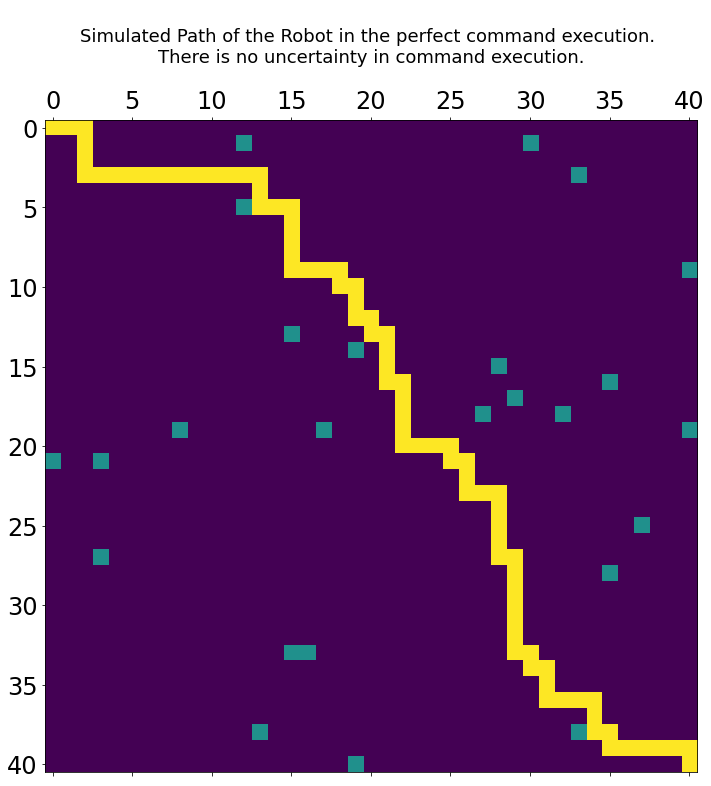

In [44]:
# Finding the optimal policy via dynamic programming

currentState = targetCell
farzad = Agent(currentState)
actionList = [(0,1),(1,0)]
iter_ = 0
J = 1
policy = []
sequence = [currentState]
while 1:

    previousStatesList_ = [[tupleAdd(currentState, tuple(np.multiply(actionList[0],-1))),tupleAdd(currentState, tuple(np.multiply(actionList[0],-1)), tuple(np.multiply(actionList[0],-1)))],
                           [tupleAdd(currentState, tuple(np.multiply(actionList[0],-1))),tupleAdd(currentState, tuple(np.multiply(actionList[0],-1)), tuple(np.multiply(actionList[1],-1)))],
                           [tupleAdd(currentState, tuple(np.multiply(actionList[1],-1))),tupleAdd(currentState, tuple(np.multiply(actionList[1],-1)), tuple(np.multiply(actionList[0],-1)))],
                           [tupleAdd(currentState, tuple(np.multiply(actionList[1],-1))),tupleAdd(currentState, tuple(np.multiply(actionList[1],-1)), tuple(np.multiply(actionList[1],-1)))]]
    
    
    removalList = []
    for x in previousStatesList_:
        if ((x[0][0] < 0)  | (x[0][1] > X)  | (x[0][0] > Y)  | (x[0][1] < 0) | (x[0] in obstacleTuples) | (x[1] in obstacleTuples)):
            removalList.append(x)
    previousStatesList = [x for x in previousStatesList_ if x not in removalList]
    
    state_action_List = []
    for state in previousStatesList:
        for action in actionList:
            if tupleAdd(state[0],action) == currentState:
                temp = state.copy()
                temp.append(action)
                state_action_List.append(temp)
    
    g = []
    for item in state_action_List:
        delta_state = tuple(np.subtract(item[0], item[1]))
        if delta_state == item[2]:
            p = [0.8, 0.2]

        if delta_state != item[2]:
            p = [0.6, 0.4]
        
        next_state_desired = tupleAdd(item[0], item[2])
        next_state_undesired = tupleAdd(item[0],actionList[1 - actionList.index(item[2])])
        g.append(gValue(next_state_desired) * p[0] + gValue(next_state_undesired) * p[1])
    
    
    
    ind = np.random.choice(np.argwhere(g == np.amax(g))[:,0],1)[0]
    # ind = np.argmax(np.array(g))
    J = np.max(g) + J
    currentState = state_action_List[ind][0]
    sequence.append(currentState)
    policy.append(state_action_List[ind][-1])
    if currentState == startCell:
        break

ax = plotSequance(sequence)
ax.set_title('\nSimulated Path of the Robot in the perfect command execution. \nThere is no uncertainty in command execution.\n',fontsize=18);  

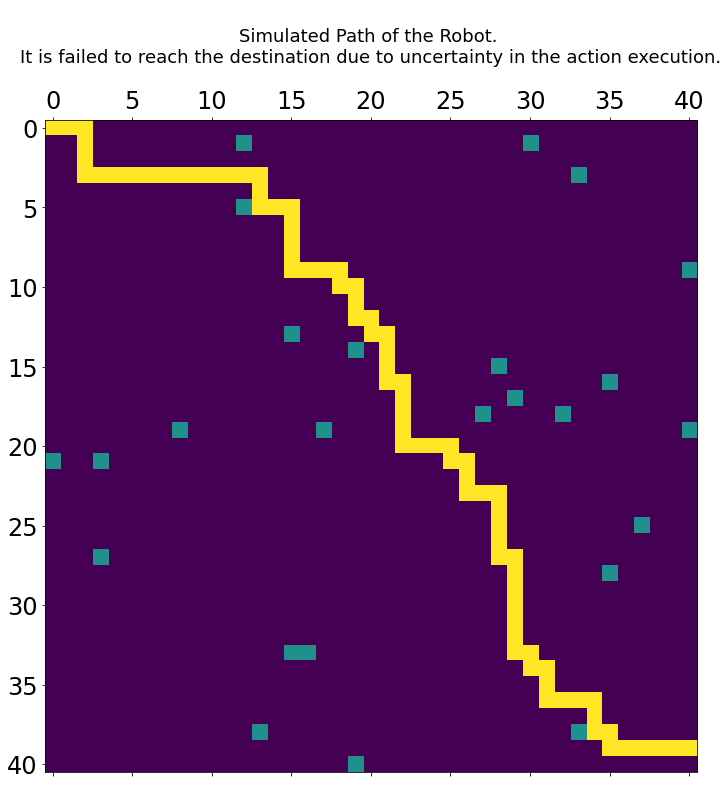

In [45]:
# Simulating the robot going from the first cell to the desired cell
farzad = Agent([(0,0)])
trajectory = TrajectoryGeneration(farzad,policy[::-1])   
ax = plotSequance(trajectory[:-1])
ax.set_title('\nSimulated Path of the Robot. \nIt is failed to reach the destination due to uncertainty in the action execution.\n',fontsize=18);  